# Data creation

In [1]:
import pandas as pd

df = pd.DataFrame({'ID':[1,2,3,4,5,6], 
                   'First Name':['Felix', 'Jean', 'James', 'Daphne', 'James', 'Peter'], 
                   'Family Name': ['Revert', 'Durand', 'Wright', 'Hull', 'Conrad', 'Donovan'],
                   'Phone number': ['+33 6 12 34 56 78', '+33 7 00 00 00 00', '+33 6 12 34 56 78', '+33 6 99 99 99 99', '+852 0123 4567', '+852 0123 4567'],
                   'Email': ['felix.revert@gmail.com', 'jean.durand@gmail.com', 'j.custom@gmail.com', pd.np.nan, 'j.custom@gmail.com', pd.np.nan]})


# G.add_nodes_from(df.ID.unique().tolist(), label='user')

<ipython-input-1-12ff8f7fc7ba>:7: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  'Email': ['felix.revert@gmail.com', 'jean.durand@gmail.com', 'j.custom@gmail.com', pd.np.nan, 'j.custom@gmail.com', pd.np.nan]})


# Data preparation

### Phone numbers

In [8]:
column_edge = 'Phone number'
column_ID = 'ID'
df

,ID,First Name,Family Name,Phone number,Email
0,1,Felix,Revert,+33 6 12 34 56 78,felix.revert@gmail.com
1,2,Jean,Durand,+33 7 00 00 00 00,jean.durand@gmail.com
2,3,James,Wright,+33 6 12 34 56 78,j.custom@gmail.com
3,4,Daphne,Hull,+33 6 99 99 99 99,NaN
4,5,James,Conrad,+852 0123 4567,j.custom@gmail.com
5,6,Peter,Donovan,+852 0123 4567,NaN


In [7]:
df[[column_ID, column_edge]].dropna(subset=[column_edge]).drop_duplicates()

,ID,Phone number
0,1,+33 6 12 34 56 78
1,2,+33 7 00 00 00 00
2,3,+33 6 12 34 56 78
3,4,+33 6 99 99 99 99
4,5,+852 0123 4567
5,6,+852 0123 4567


In [9]:
data_to_merge = df[[column_ID, column_edge]].dropna(subset=[column_edge]).drop_duplicates() # select columns, remove NaN

#找到有相同的
data_to_merge = data_to_merge.merge(
    data_to_merge[[column_ID, column_edge]].rename(columns={column_ID:column_ID+"_2"}), 
    on=column_edge
)

In [10]:
data_to_merge

,ID,Phone number,ID_2
0,1,+33 6 12 34 56 78,1
1,1,+33 6 12 34 56 78,3
2,3,+33 6 12 34 56 78,1
3,3,+33 6 12 34 56 78,3
4,2,+33 7 00 00 00 00,2
5,4,+33 6 99 99 99 99,4
6,5,+852 0123 4567,5
7,5,+852 0123 4567,6
8,6,+852 0123 4567,5
9,6,+852 0123 4567,6


In [11]:
data_to_merge[~(data_to_merge[column_ID]==data_to_merge[column_ID+"_2"])] \
    .dropna()[[column_ID, column_ID+"_2", column_edge]]

,ID,ID_2,Phone number
1,1,3,+33 6 12 34 56 78
2,3,1,+33 6 12 34 56 78
7,5,6,+852 0123 4567
8,6,5,+852 0123 4567


In [12]:
#把和自己相同的记录删掉
d = data_to_merge[~(data_to_merge[column_ID]==data_to_merge[column_ID+"_2"])] \
    .dropna()[[column_ID, column_ID+"_2", column_edge]]
    
#一对记录只保留一条
d.drop(d.loc[d[column_ID+"_2"]<d[column_ID]].index.tolist(), inplace=True)

In [13]:
d

,ID,ID_2,Phone number
1,1,3,+33 6 12 34 56 78
7,5,6,+852 0123 4567


### Creation of the graph

In [14]:
import networkx as nx

G = nx.from_pandas_edgelist(df=d, source=column_ID, target=column_ID+'_2', edge_attr=column_edge)

G.add_nodes_from(nodes_for_adding=df.ID.tolist())

In [15]:
G.nodes()

NodeView((1, 3, 5, 6, 2, 4))

### Emails

In [16]:
column_edge = 'Email'
column_ID = 'ID'

data_to_merge = df[[column_ID, column_edge]].dropna(subset=[column_edge]).drop_duplicates()

data_to_merge = data_to_merge.merge(
    data_to_merge[[column_ID, column_edge]].rename(columns={column_ID:column_ID+"_2"}), 
    on=column_edge
)

d = data_to_merge[~(data_to_merge[column_ID]==data_to_merge[column_ID+"_2"])] \
    .dropna()[[column_ID, column_ID+"_2", column_edge]]

d.drop(d.loc[d[column_ID+"_2"]<d[column_ID]].index.tolist(), inplace=True)

In [17]:
d

,ID,ID_2,Email
3,3,5,j.custom@gmail.com


In [18]:
# Create the connections in the graph
links_attributes = {tuple(row[[column_ID, column_ID+"_2"]]): {column_edge: row[column_edge]} for i,row in d.iterrows()}

G.add_edges_from(links_attributes) # create the connection, without attribute. Check it with G.get_edge_data(3,5)
nx.set_edge_attributes(G=G, values=links_attributes) # adds the attribute. Check it with G.get_edge_data(3,5)

# Graph analysis

### Drawing graphs

In [19]:
%matplotlib inline

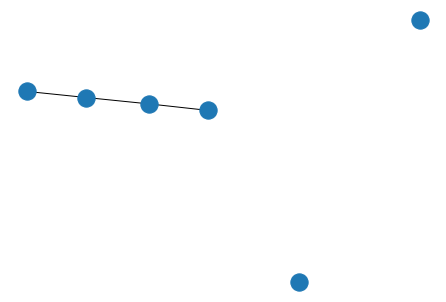

In [20]:
nx.draw(G)

In [21]:
{row[column_ID]:row['First Name'] +' '+ row['Family Name'] for i,row in df.iterrows()}

{1: 'Felix Revert',
 2: 'Jean Durand',
 3: 'James Wright',
 4: 'Daphne Hull',
 5: 'James Conrad',
 6: 'Peter Donovan'}

In [22]:
nx.set_node_attributes(G, {row[column_ID]:{'Name': row['First Name'] +' '+ row['Family Name']} for i,row in df.iterrows()})

In [23]:
EDGE_SIZE = {
    'Phone number': 2,
    'Email': 1,
}

EDGE_COLOR = {
    'Phone number': 'purple',
    'Email': 'red',
}

def clean_edge(edge):
    s.edge[edge[0], edge[1]].values()

def c_(list_edges): return [a for a in list_edges if a in list(EDGE_COLOR.keys())]
    
# For nx.Graph()
def edge_sizes(s): return [EDGE_SIZE[c_(list(s.edges[edge[0], edge[1]].keys()))[-1]] for edge in s.edges()] # /!\ multiple links => one size
def edge_colors(s): return [EDGE_COLOR[c_(list(s.edges[edge[0], edge[1]].keys()))[-1]] for edge in s.edges()] # /!\ multiple links => one color

# For nx.MultiDiGraph()
# def edge_sizes(s): return [EDGE_SIZE[s.edge[edge[0]][edge[1]][0]['label']] for edge in s.edges()] # /!\ multiple links => one size
# def edge_colors(s): return [EDGE_COLOR[s.edge[edge[0]][edge[1]][0]['label']] for edge in s.edges()] # /!\ multiple links => one color

def draw(s):
    pos = nx.spring_layout(s, scale=0.5)
    node_labels = dict((n,d['Name']) for n,d in s.nodes(data=True))
#     labels = {**node_labels, **edge_labels}
    nx.draw(s, pos=pos, width=edge_sizes(s), edge_color=edge_colors(s), alpha=0.8, arrows=False, node_color='lightgrey', node_size=400,
            labels=node_labels, 
            font_color='black', font_size=8, font_weight='bold',
           )
    edge_labels = dict(((u,v),list(d.values())[0]) for u,v,d in G.edges(data=True))
    nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, font_size=8)

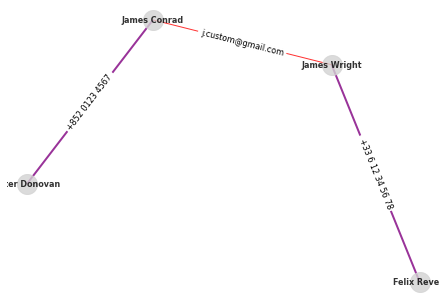

In [24]:
draw(nx.ego_graph(G=G, n=1, radius=3))

### Automated detection of strange patterns

In [25]:
degrees = list(nx.degree(G))

In [26]:
pd.DataFrame([list(d) for d in degrees], columns=['ID', 'degree']).sort_values('degree', ascending=False).head(5)

,ID,degree
1,3,2
2,5,2
0,1,1
3,6,1
4,2,0


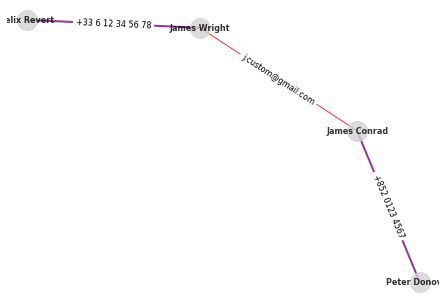

In [27]:
draw(nx.ego_graph(G=G, n=3, radius=2))

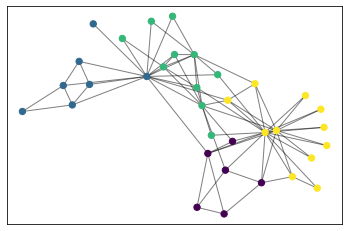

In [1]:
from community import community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx

# load the karate club graph
G = nx.karate_club_graph()

# compute the best partition
partition = community_louvain.best_partition(G)

# draw the graph
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

In [14]:
partition = community_louvain.best_partition(G)

In [21]:
partition.values()

dict_values([0, 0, 0, 0, 2, 2, 2, 0, 3, 3, 2, 0, 0, 0, 3, 3, 2, 0, 3, 0, 3, 0, 3, 3, 1, 1, 3, 3, 1, 3, 3, 1, 3, 3])

In [16]:
from community import modularity

In [17]:
modularity(partition, G)

0.4151051939513478